# RNA-Seq Pipeline for Wang et al.

Notebook prepared by Alex Wang & Allysa Allen

Last updated: 03/04/2021

If useful, please cite the original paper: Wang A., Allen A., Sofman M., Sphabmixay P., Yildiz E., Griffth L. "Engineering Modular 3D Liver Culture Microenvironments In Vitro to Parse the Interplay between Biophysical and Biochemical Microenvironment Cues on Hepatic Phenotypes" (Submitted). 

This jupyter notebook is a more detailed methodology walkthrough of the bulk RNA-Seq analysis performed in Wang et al. Given the GSE raw sequence files or processed count data, this code will generate the graphs provided in the paper, as well as additional analysis techniques that may be of interest. Some graphs were exported as SVGs and manipulated in Adobe Illustrator for layout purposes. We hope that this code will be of use for researchers utilizing bulk RNA-sequencing in other applications. Note that this code was written for the sake of clarity (by researchers not formally trained in coding) rather than for speed or elegance. 

1. [Preparation](#Preparation)  
    1.1 [R and RStudio](#R-and-RStudio)  
    1.2 [Bioconductor](#Bioconductor)  
    1.3 [Acquiring data & using this document](#Acquiring-data-&-using-this-document)
2. [Transcript alignment and abundance](#Transcript-alignment-and-abundance)  
    2.1 [STAR Alignment](#STAR-Alignment)  
    2.2 [RSEM Quantification](#RSEM-Quantification)
3. [Pooling](#Pooling)  
    3.1 [tximport](#tximport)  
    3.2 [Removing nonprotein-coding genes](#Removing-nonprotein-coding-genes)
4. [Translating between Ensembl IDs and gene names](#Translating-between-Ensembl-IDs-and-gene-names)  
    4.1 [Ensembl IDs to gene names](#Ensembl-IDs-to-gene-names)  
    4.2 [Gene names to Ensembl IDs](#Gene-names-to-Ensembl-IDs)  
5. [Analysis with DESeq2](#Analysis-with-DESeq2)  
    5.1 [Creating a DESeqDataSet](#Creating-a-DESeqDataSet)  
    5.2 [Pre-filtering low counts](#Pre-filtering-low-counts)  
6. [Principal component analysis](#Principal-component-analysis)  
    6.1 [PC plots](#PC-plots)  
    6.2 [Loadings plots](#Loadings-plots)
7. [Differential expression analysis](#Differential-expression-analysis)  
    7.1 [Volcano plots](#Volcano-plots)
8. [Enrichment analysis](#Enrichment-analysis)  
    8.1 [topGO](#topGO)  
    8.2 [Gene Set Enrichment Analysis](#Gene-set-enrichment-analysis)  
    8.3 [Fold change gene set heatmaps](#Fold-change-gene-set-heatmaps)
9. [Venn diagram: overlapping DEGs and enrichment terms](#Venn-diagram:-overlapping-DEGs-and-enrichment-terms)

## Preparation

### R and RStudio

The bulk of the analysis is performed in RStudio. The latest version of R is found [here](https://cran.rstudio.com/) and RStudio can be found [here](https://rstudio.com/products/rstudio/download/). The following work with the exception of alignment will be done with R 4.0.2 x64 on MacOS Catalina. Windows will require modifications to filepaths but otherwise should be similar. 

### Bioconductor

[Bioconductor](https://www.bioconductor.org/) hosts a variety of tools useful for analysing transcriptomic data. Installing BiocManager allows you to easily install any further Bioconductor supported packages. An example is shown below.  
**Disclaimer:** An installation line will be listed before any new package is used. However, many packages have other dependencies, so install any missing things as necessary. 

In [1]:
#if(!requireNamespace("BiocManager", quietly= TRUE))
#    install.packages("BiocManager")
#BiocManager::install(version="3.11")

### Acquiring data & using this document

Public data sets can be found in the [Gene Expression Omnibus (GEO)](https://www.ncbi.nlm.nih.gov/geo/) supported by NCBI. Additional data sets or file formats can also be found in the [European Nucleotide Archive (ENA)](https://www.ebi.ac.uk/ena/browser/home).  
For this paper, the GSE files are found here: (link to be added)  
To use this document within jupyter or RStudio, you'll need to download or have the associated files for each section. The transcript alignment and subsequent processing steps will be detailed, but a processed .Rdata file will be included in the Github page (not done yet). Additionally, all files and the Rstudio / jupyter notebook must be within or set to a single working directory. 

## Transcript alignment and abundance 

### STAR Alignment


[STAR](https://github.com/alexdobin/STAR) (Spliced Transcripts Alignment to a Reference) provides direct mapping of transcripts onto a reference genome. This method may be more appropriate for short, single-end read transcripts but has the disadvantage over pseudoaligners such as kallisto due to it requiring large amounts of RAM and processor power. For support, refer to the linked Github, as well as this [protocol paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4631051/pdf/nihms722197.pdf) that most of the code is based on and the [Google Group](https://groups.google.com/g/rna-star).  
Installation: 
First, install STAR from the home directory into ~/star/code in a Linux-based operating system. The code here uses STAR v2.7.5c on Ubuntu with 32GB of RAM. This code is run in terminal, NOT RStudio or jupyter!


#### Generate Genome Index
It is highly recommended to generate the genome using custom settings. See STAR manual for how to download pre-indexed genomes.   
First, download the genome and annotation file.

In [ ]:
# Get the most recent public release and match the versions for annotations and DNA assembly
cd ~/star
wget ftp://ftp.ensembl.org/pub/release-101/gtf/homo_sapiens/Homo_sapiens.GRCh38.101.gtf.gz
gunzip Homo_sapiens.GRCh38.101.gtf.gz 

mkdir -p ~/star/genome
cd ~/star/genome
wget ftp://ftp.ensembl.org/pub/release-101/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
gunzip Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz

The genome generation step requires ~35Gb RAM without special settings. Here we run with settings for a 32Gb, 8-threaded processor desktop. --runThreadN 8 --genomeSAsparseD 2 and --limitGenomeGenerateRAM 25000000000 settings will be changed based on the computing power. --sjdbOverhang 39 is (Readlength -1), but should be modified based on the sequencing conditions. For longer reads, an sjdvOverhang overestimate is better than an underestimate. 

In [ ]:
# your version of STAR may be different
cd ~/star/genome
~/star/code/STAR-2.7.5c/bin/Linux_x86_64/STAR --runThreadN 8  --genomeSAsparseD 2 --limitGenomeGenerateRAM 25000000000 --runMode genomeGenerate --genomeDir ./ --genomeFastaFiles Homo_sapiens.GRCh38.dna.primary_assembly.fa --sjdbGTFfile ~/star/Homo_sapiens.GRCh38.101.gtf --sjdbOverhang 39

Output   
..... started STAR run  
... starting to generate Genome files  
... starting to sort Suffix Array. This may take a long time...  
... sorting Suffix Array chunks and saving them to disk...  
... loading chunks from disk, packing SA...  
... finished generating suffix array  
... generating Suffix Array index  
... completed Suffix Array index 
... writing Genome to disk ...  
... writing Suffix Array to disk ...  
... writing SAindex to disk  
..... finished successfully


#### Mapping Reads

Place all the .fastq files into the STAR directory and run the next command in the ~/star terminal. If they are .fastq.gz or paired-end reads, see the STAR tutorial for how to modify the settings. These settings are based on discussions in the Google Group as well as [Trapecar et al.](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(20)30078-8), which is based on ENCODE options. The terminal loop will create folders and mappings for each individual .fastq sequencing file in the ~/star folder. 

In [ ]:
# settings tweaked for short 40nt reads and by Trapecar et al methods. Must run in /star folder. Delete seedSearchStartLMax for longer reads.
for file in *.fastq; do mkdir ~/star/"$file"_run; cd ~/star/"$file"_run; ~/star/code/STAR-2.7.5c/bin/Linux_x86_64/STAR --runThreadN 8  --genomeDir ~/star/genome/ --sjdbGTFfile ~/star/Homo_sapiens.GRCh38.101.gtf --sjdbOverhang 39 --readFilesIn ~/star/"$file" --outFilterType BySJout -outFilterMultimapNmax 20 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 --outFilterMismatchNmax 999 --alignIntronMin 10 --alignIntronMax 1000000 --alignMatesGapMax 1000000 --seedSearchStartLmax 25 --outSAMtype BAM SortedByCoordinate --quantMode TranscriptomeSAM; done

Output:  
..... started STAR run  
..... loading genome  
..... processing annotations GTF  
..... inserting junctions into the genome indices  
..... started mapping  
..... finished mapping  
..... started sorting BAM  
..... finished successfully;

Go into the folders and examine Log.final.out for summary statistics. 90%+ of your reads should be mapped, though the numer of uniquely mapped reads may be lower if there is significant rRNA contamination. 

### RSEM Quantification

[RSEM](https://deweylab.github.io/RSEM/) (RNA-Seq by Expectation Maximization) quantifies transcript abundances from the mapped reads. For documentation, we rely on the STAR tutorial paper and Trapecar et al. for specific settings (see previous section).  This code is directly after STAR alignment. 
First, install RSEM into ~/star/code

#### Prepare RSEM Reference files

In [ ]:
# your version of RSEM may be different
mkdir ~/star/rsem_ref
cd ~/star/code/RSEM-1.3.3
./rsem-prepare-reference --gtf ~/star/Homo_sapiens.GRCh38.101.gtf ~/star/genome/Homo_sapiens.GRCh38.dna.primary_assembly.fa ./ref

Move the .ref files manually out of the ~/star/code/RSEM-1.3.3 folder into the ~/star/rsem_ref folder.

#### Quantify transcripts

We now loop through our STAR folders (ending in "_run") to generate Quant.genes.results for tximport. There is no output message when completed. Transfer all "_run" folders into a new folder called "Sequences" in your main RNA-Seq working directory. The rest of the code will be done using RStudio on MacOS, but can also be easily done on Windows systems. 

In [ ]:
# this takes a long time
for dir in *_run/; do cd ~/star/code/RSEM-1.3.3; ./rsem-calculate-expression --bam --no-bam-output --calc-pme --p 8 --forward-prob 0 ~/star/"$dir"/Aligned.toTranscriptome.out.bam ~/star/rsem_ref/ref ~/star/"$dir"/Quant >& ~/star/"$dir"/rsem.log; done


## Pooling

### tximport

[tximport](https://f1000research.com/articles/4-1521/v1) is responsible for importing and summarizing transcript-level abundance estimates for transcript- and gene-level analysis. [Their vignette guide](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html#Introduction) documents how to use tximport with varying alignment and downstream softwares.  
First, you need to install and load the relevant packages. This includes `ensembldb`, which supports the Ensembl database, `EnsDb.Hsapiens.v86`, which is the annotation database equivalent to hg38/GRCh38. And of course, `tximport`.

In [2]:
# BiocManager::install("tximport")
# BiocManager::install("ensembldb") 
# BiocManager::install("EnsDb.Hsapiens.v86")

setwd("~/Documents/RNAseqexp") # change to your working directory
suppressPackageStartupMessages({
    library(ensembldb)
    library(EnsDb.Hsapiens.v86)
    library(tximport)
    library(tidyverse)
})

We use `transcripts()` to pull transcript identification and location information and return `txdf` as a usable data frame. From `txdf` we pull only the transcript ID and gene ID columns, creating what is essentially a conversion table: `tx2gene`. This column order must be used. And be sure that that transcript IDs used in `tx2gene` match the IDs used to align to the transcriptome. (EnsDb.Hsapiens.v86 == Hsapiens.GRCh38)

In [4]:
txdf<-transcripts(EnsDb.Hsapiens.v86, return.type="DataFrame")
tx2gene<-as.data.frame(txdf[, c("tx_id", "gene_id")])

We now create a metadata "samples.txt" file which contains the column headers: "sample, experiment, run, and condition". We specify "sample" names as numbers from 1-18 for convenience. "run" specifies the folder names of the alignment files generated from STAR+RSEM, containing "*_run" at the end of the folder name and has "Quant.genes.results" in each folder. The "condition" specifies different conditions for each sample. Replicates should have the exact sample condition name. This .txt table is placed in a folder called "Metadata" in the working directory. ;
We pull our metadata table in the environment. Then we create a named vector that points to the location of the quantification files. The files can be named arbitrarily sample1-18, or with their respective sample number by exchanging `paste0(samples$run)`. ;
Last, we generate a list of matrices, `txi.rsem`, one of which is our raw read counts matrix.;
There may be warning messages that can be ignored. 

In [5]:
samples<-read.table(file.path("Metadata", "samples.txt"),header=TRUE)
files<-file.path("Sequences", samples$run, "Quant.genes.results")
names(files)<-paste0("sample", 1:18)
txi.rsem <- tximport(files, type = "rsem", txIdCol = transcript_id(s), tx2gene = tx2gene, ignoreTxVersion = TRUE, txIn = FALSE, txOut = FALSE)
head(txi.rsem$counts)

# saving raw count matrix before filtering steps
write.csv(txi.rsem$counts, file="RNAseq_read_counts_raw.csv")

reading in files with read_tsv

1 
Warning message:
"Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two."
Warning message:
"60671 parsing failures.
row col  expected     actual                                                                     file
  1  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2452_NA_sequence.fastq_run/Quant.genes.results'
  2  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2452_NA_sequence.fastq_run/Quant.genes.results'
  3  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2452_NA_sequence.fastq_run/Quant.genes.results'
  4  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2452_NA_sequence.fastq_run/Quant.genes.results'
  5  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2452_NA_sequence.fastq_run/Quant.genes.results'
... ... ......... .......... ........................................................................
See problems(...) for more details.
"
2 
Warning message:
"Unnamed `col_types` should have the same 

Warning message:
"60671 parsing failures.
row col  expected     actual                                                                     file
  1  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2459_NA_sequence.fastq_run/Quant.genes.results'
  2  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2459_NA_sequence.fastq_run/Quant.genes.results'
  3  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2459_NA_sequence.fastq_run/Quant.genes.results'
  4  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2459_NA_sequence.fastq_run/Quant.genes.results'
  5  -- 7 columns 11 columns 'Sequences/200707Gri_D20_2459_NA_sequence.fastq_run/Quant.genes.results'
... ... ......... .......... ........................................................................
See problems(...) for more details.
"
11 
Warning message:
"Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two."
Warning message:
"60671 parsing failures.
row col  expected     actual                       

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10,sample11,sample12,sample13,sample14,sample15,sample16,sample17,sample18
ENSG00000000003,755.20,785.05,949.00,564.5,591.05,486.49,266.26,175.00,259,756,786.01,824.00,588.96,583.94,298.01,339.00,804.00,411.34
ENSG00000000005,2.00,1.00,2.00,0.0,0.00,0.00,3.00,2.00,0,1,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
ENSG00000000419,79.01,93.00,111.02,93.0,126.00,73.00,47.00,24.00,40,81,77.00,89.36,161.00,145.03,78.00,65.00,73.00,59.00
ENSG00000000457,68.00,86.02,138.46,120.0,115.38,102.00,44.00,37.95,21,145,176.44,155.07,198.00,141.98,84.00,64.39,89.28,84.98
ENSG00000000460,11.00,15.00,11.00,3.0,14.00,7.00,13.00,8.38,0,10,15.00,16.00,14.80,15.00,5.00,8.00,15.00,11.00
ENSG00000000938,4.00,9.00,5.00,5.0,7.00,9.00,10.00,3.00,7,1,0.00,2.00,31.00,68.00,29.00,21.00,10.00,16.00


### Removing nonprotein-coding genes

In this study, we were mostly interested in differential reponses to protein-coding genes that are listed in curated pathway databases. As such, we filtered out non-chromosomal protein-coding genes from downstream analysis. Adding or removing this filtering step did not significantly affect the main conclusions of the paper. If this step isn't performed, you will find non-coding lnc, sno, mt-mRNAs that are differentially regulated. ; First, a list of chromosomal protein-coding genes are were downloaded from Biomart as a .txt and saved in the working directory. 

In [6]:
# This process searches through a list of protein-coding genes downloaded from Biomart
pgenes <- read.table("protein_coding_genes_noMT.txt", header=TRUE, sep ="\t")
pgenes <- unique(pgenes$Gene.stable.ID)

keep<- c()

for (x in 1:nrow(txi.rsem$counts)){
    keep<-append(keep,rownames(txi.rsem$counts)[x] %in% pgenes) }

# remove noncoding genes
txi.rsem$counts <- txi.rsem$counts[keep,]
txi.rsem$length <- txi.rsem$length[keep,]
txi.rsem$abundance <- txi.rsem$abundance[keep,]

# save txi data file
save(txi.rsem, file = "txi.rsem.RData")

## Translating between Ensembl IDs and gene names

### Ensembl IDs to gene names

While we perform analysis with the genes as EnsemblIDs, at some point we will plot with standard gene names, as they are far more recognizable. For this, we'll use `biomaRt`. This package simply allows us to query the [BioMart](http://uswest.ensembl.org/biomart/martview/f91dfb2561f14b90d5c8e67300adefde) database, as you can online. If you want a tutorial on how to do this process on the web, this [youtube video](https://www.youtube.com/watch?v=OIAuBoUPOHw) is helpful.  
First, we need to pull the correct BioMart database. For human, we'll use the GRCh38.p13 build.

In [8]:
#BiocManager::install("biomaRt")
suppressPackageStartupMessages(library(biomaRt))

ensembl= useMart("ENSEMBL_MART_ENSEMBL")
ensembl= useDataset("hsapiens_gene_ensembl", mart= ensembl)

Then we'll put which attributes from the mart we'd like. 

In [9]:
attribs <-c("ensembl_gene_id", "external_gene_name")
annot <- getBM(attributes= attribs, mart= ensembl)

From here, we create a matrix, where the Ensembl gene IDs are the row names and the values are the gene names. 

In [11]:
id2gene=data.frame(gene_name=annot[,c("external_gene_name")])
rownames(id2gene)= annot[,c("ensembl_gene_id")]
head(id2gene)
save(id2gene, file="id2gene.Rdata")

,gene_name
,<chr>
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1
ENSG00000198888,MT-ND1


With this matrix, you just need a quick `for` loop to query the `id2gene` object whenever you need to have gene names. This processes is relatively inefficient and slow.  

In [12]:
#for (x in 1:nrow(GENERIC)){GENERIC$gene_name[x]<- id2gene[rownames(GENERIC)[x], "gene_name"]}

### Gene names to Ensembl IDs

And to do the reverse, we'll just co-op the `annot` data we just pulled to write the complimentary dictionary. This is not as straight forward due to the multi-mapping problem of gene names to Ensembl IDs. Alternative gene sequences have unique Ensembl IDs but the same gene name. Fortunately, the primary sequence is the numerically lowest ID, so the primary sequence is the first Ensembl ID to come across in the list. 

In [13]:
gene2id=data.frame(id=annot[,c("ensembl_gene_id")], gene= annot[,c("external_gene_name")])
temp<-c()
keep<-c()

for (x in 1:nrow(gene2id)){
    if (!(gene2id[x, "gene"] %in% temp)){
        temp<-append(temp, gene2id[x, "gene"])
        keep<-append(keep, TRUE)} 
    else{keep<-append(keep, FALSE)}
}
gene2id<-gene2id[keep,]

rownames(gene2id)<-temp
gene2id<-gene2id[ , "id", drop=FALSE]
save(gene2id, file="gene2id.Rdata")

And to query the `gene2id` object use a similar for loop:

In [14]:
#for (x in 1:nrow(GENERIC)){GENERIC$id[x]<-gene2id[rownames(GENERIC)[x], "id"]}

## Analysis with DESeq2

[DESeq2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8) is a method of differential analysis for count data modeled using a negative binomial distribution. A helpful guide exists for using [DESeq2](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).

### Creating a DESeqDataSet

First a DESeqDataSet must be created, which is a particular class of object required for all downstream analysis. Fortunately, DESeq2 has a streamlined function `DESeqDataSetFromTximport()`. The argument `colData` needs the metadata information as prepared earlier.

In [3]:
#BiocManager::install(“DESeq2”)
suppressPackageStartupMessages(library(DESeq2))

# Load previously generated .RData files to save time
samples<-read.table(file.path("Metadata", "samples.txt"),header=TRUE)
load(file.path("txi.rsem.RData"))
load(file.path("gene2id.RData"))
load(file.path("id2gene.RData"))

# Pre-format to delete all 0 rows. This particular step may not be necessary depending on software versions. 
txi.rsem$abundance <-txi.rsem$abundance[apply(txi.rsem$length, 1, function(row) all(row !=0 )),]
txi.rsem$counts <-txi.rsem$counts[apply(txi.rsem$length, 1, function(row) all(row !=0 )),]
txi.rsem$length <-txi.rsem$length[apply(txi.rsem$length, 1, function(row) all(row !=0 )),]
ddsTxi<-DESeqDataSetFromTximport(txi.rsem, colData=samples, design= ~condition)
                                        

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
using counts and average transcript lengths from tximport



### Pre-filtering low counts

From this DataSet object, we perform pre-filtering to remove any genes with very low counts. In our methodology, genes must have >=1 CPM in all replicates and all conditions. Applying the logical vector `keep` to `ddsTxi` will keep any rows marked `TRUE` and discard any rows marked `FALSE`. Rows marked `TRUE` need to pass the CPM threshold. We create 6 individual condition vectors for each of our conditions and assume 3 replicates - this should be adjusted / modified depending on how many unique conditions and replicates you have. 

In [4]:
cpm_table<-matrix(1:(nrow(ddsTxi)*(nrow(samples))), ncol=nrow(samples))
mil_factor<- colSums(counts(ddsTxi))/1000000  

temp<-c(1:nrow(samples))
names(temp)<-samples$condition
conds<-unique(names(temp))
cond1<-unname(temp[names(temp)==conds[1]])
cond2<-unname(temp[names(temp)==conds[2]])
cond3<-unname(temp[names(temp)==conds[3]])
cond4<-unname(temp[names(temp)==conds[4]])
cond5<-unname(temp[names(temp)==conds[5]])
cond6<-unname(temp[names(temp)==conds[6]])

for (x in 1:ncol(ddsTxi)){
    cpm_table[,x]<-counts(ddsTxi)[,x]/mil_factor[x]
}
keep<-c()
for (x in 1:nrow(ddsTxi)){
    count1=0
    count2=0
    count3=0
    count4=0
    count5=0
    count6=0
    for (y in cond1){
        if (cpm_table[x,y]>=1){count1=count1+1}
    }
    for (y in cond2){
        if (cpm_table[x,y]>=1){count2=count2+1}
    }
        for (y in cond3){
        if (cpm_table[x,y]>=1){count3=count3+1}
    }
        for (y in cond4){
        if (cpm_table[x,y]>=1){count4=count4+1}
    }
        for (y in cond5){
        if (cpm_table[x,y]>=1){count5=count5+1}
    }
        for (y in cond6){
        if (cpm_table[x,y]>=1){count6=count6+1}
    }
    counts<-c(count1, count2, count3, count4, count5, count6)
    if (length(which(counts>=3))==6){keep<-append(keep, TRUE)}
    else{keep<-append(keep, FALSE)}
}

# ddsTxi is now modified with the filtering vector
ddsTxi<-ddsTxi[keep,]
head(ddsTxi)

# save fully processed counts
write.csv(counts(ddsTxi), file="RNAseq_read_counts_processed.csv")

class: DESeqDataSet 
dim: 6 18 
metadata(1): version
assays(2): counts avgTxLength
rownames(6): ENSG00000000003 ENSG00000000419 ... ENSG00000001036
  ENSG00000001084
rowData names(0):
colnames(18): sample1 sample2 ... sample17 sample18
colData names(4): sample experiment run condition

## Principal component analysis

DESeq2 also offers rather simple ways to create PCA plots. `plotPCA` works well, but for more control over the data, we'll run a more manual code. First, we will use a regularized-log transformation on the counts matrix. See this [helpful guide](https://www.huber.embl.de/users/klaus/Teaching/DESeq2Predoc2014.html#pca-and-sample-heatmaps).  

In [18]:
rld<-rlogTransformation(ddsTxi, blind=TRUE)
rlogs <- assay(rld)

#save rlog counts with gene names. Comment out for speed. 
for (x in 1:nrow(rlogs)){
     rownames(rlogs)[x] <- id2gene[rownames(assay(rld))[x], "gene_name"]}
write.csv(rlogs, file = "rlogcounts_genenames.csv")


using 'avgTxLength' from assays(dds), correcting for library size



For PCA visualization, you can take a subset of the data, such as the 500 genes with the greatest variance, or you can plot the conditions with all the data.

### PC plots

First, create a vector with the variance of each row, `Pvars`. Then create a selection vector to apply to the transformed matrix, `select`. This is exactly what `plotPCA` would be running in the background, depending on what `ntop` you feed the function.  We then generate the PCA data and determine what percent variance each principal component is responsible for. 

In [19]:
PCA<- prcomp(t(assay(rld)), scale=F)
percentVar<-round(100*PCA$sdev^2/sum(PCA$sdev^2), 1)

To plot this data with `ggplot()`, we have to extract the data we want into a data frame. Then we can plot it appropriately. To group and label objects we use `ggforce()` and to save plots as SVG format we use `svglite()`

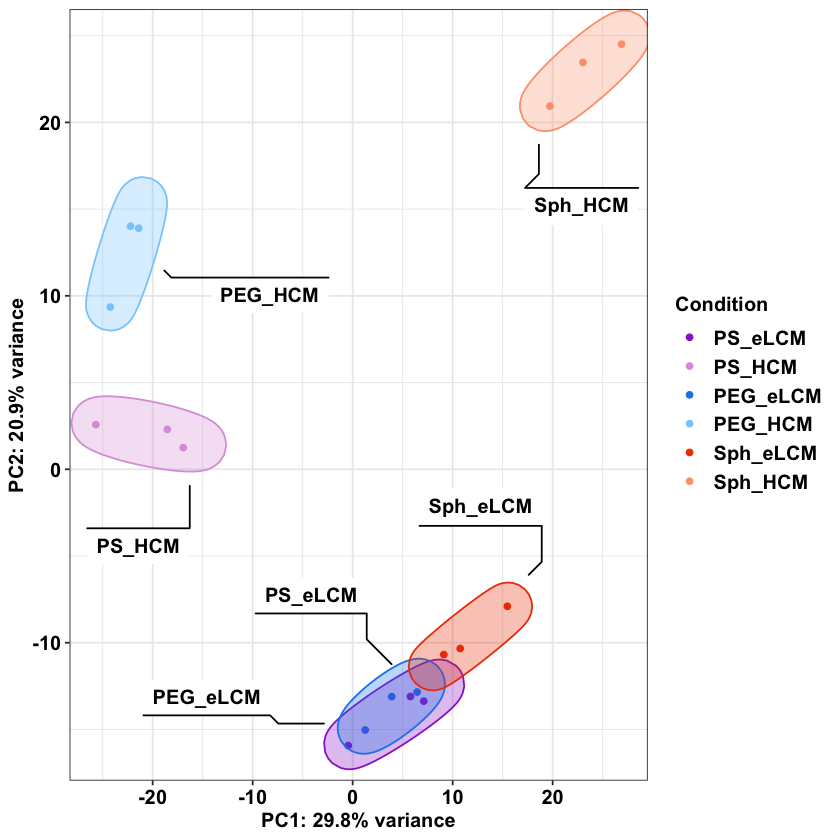

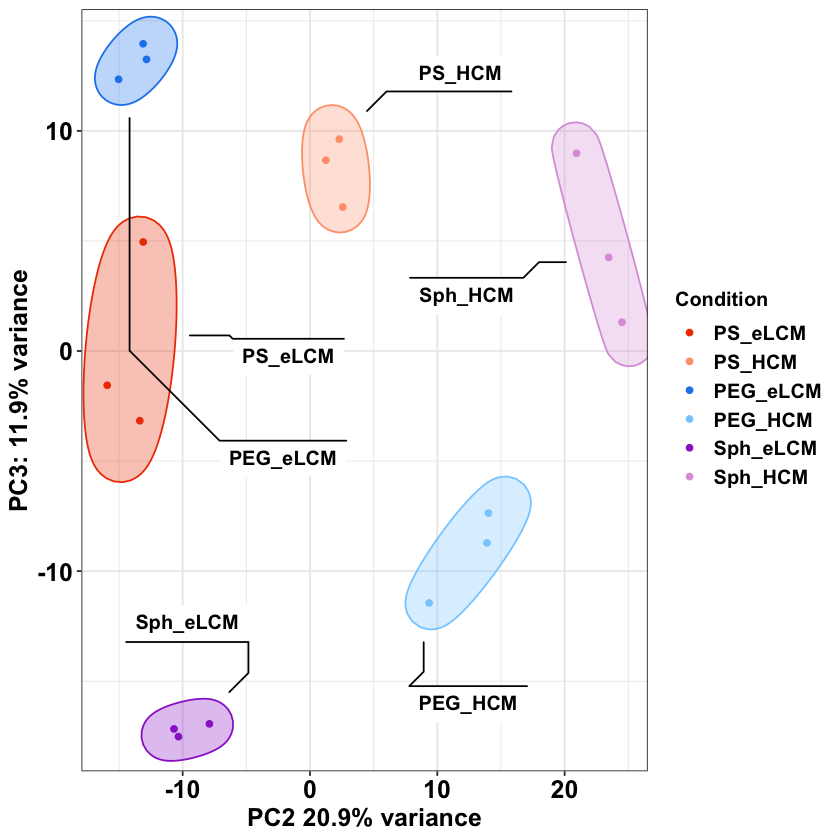

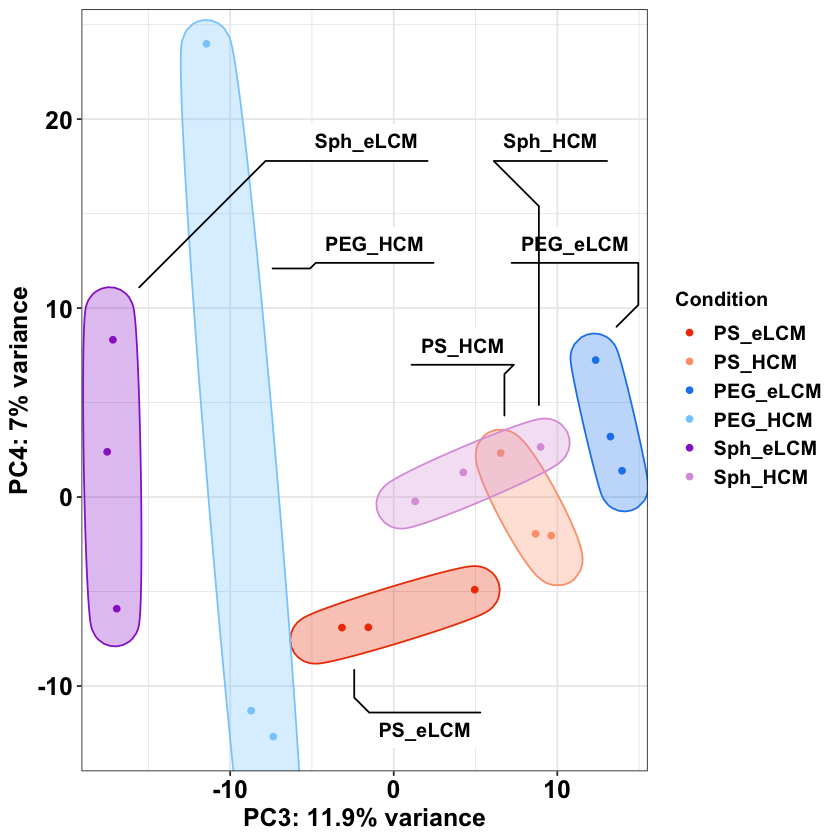

In [20]:
#BiocManager::install(“ggplot”)
#install.packages("ggforce")
#install.packages("svglite")
suppressPackageStartupMessages(library(ggforce))
suppressPackageStartupMessages(library(ggplot2))

#PC1 and PC2
PCA_data= data.frame(PC1= PCA$x[,1], PC2= PCA$x[,2], 
                     sample=colData(rld)$sample, 
                     condition= colData(rld)$condition)
PCA_data$condition<-factor(PCA_data$condition, levels=c(conds[2], conds[1], conds[4], conds[3], conds[6], conds[5]))

ggplot(PCA_data, aes(PC1, PC2, color=condition, group=condition))+
    geom_point()+
    scale_fill_manual(values=c("darkorchid3", "plum", "dodgerblue2", "skyblue1", "orangered2", "lightsalmon"))+
    scale_color_manual(values=c("darkorchid3", "plum", "dodgerblue2", "skyblue1", "orangered2", "lightsalmon"))+
    labs(x= paste0("PC1: ", round(percentVar[1], 4), "% variance"), 
         y= paste0("PC2: ", round(percentVar[2], 4), "% variance"),
         color= "Condition")+
    theme_bw()+
    theme(
        legend.position="right",legend.direction="vertical",
        legend.title=element_text(color="black", size=12, face="bold"),
        legend.text=element_text(color="black", size=12, face="bold"),
        axis.text.x=element_text(color="black", size=12, face="bold"),
        axis.text.y=element_text(color="black", size=12,face="bold"),
        axis.title=element_text(color="black", size=12, face="bold"))+
     geom_mark_ellipse(aes(fill = condition, color = condition, label = condition),show.legend=FALSE, n=100)
                                        
    ggsave(paste0("PCA1-2.png"), width=10, height=8) 
    ggsave(paste0("PCA1-2.svg"), width=9, height=7)

#PC2 and PC3
    PCA_data= data.frame(PC2= PCA$x[,2], PC3= PCA$x[,3], 
                      sample=colData(rld)$sample, 
                      condition= colData(rld)$condition)
    PCA_data$condition<-factor(PCA_data$condition, levels=c(conds[2], conds[1], conds[4], conds[3], conds[6], conds[5]))
    
    ggplot(PCA_data, aes(PC2, PC3, color=condition, group=condition))+
    geom_point()+
    scale_fill_manual(values=c("orangered2", "lightsalmon", "dodgerblue2", "skyblue1", "darkorchid3", "plum"))+
    scale_color_manual(values=c("orangered2", "lightsalmon", "dodgerblue2", "skyblue1", "darkorchid3", "plum"))+
    labs(x= paste0("PC2 ", round(percentVar[2], 4), "% variance"), 
         y= paste0("PC3: ", round(percentVar[3], 4), "% variance"),
         color= "Condition")+
    theme_bw()+
    theme(
        legend.position="right",legend.direction="vertical",
        legend.title=element_text(color="black", size=12, face="bold"),
        legend.text=element_text(color="black", size=12, face="bold"),
        axis.text.x=element_text(color="black", size=15, face="bold"),
        axis.text.y=element_text(color="black", size=15,face="bold"),
        axis.title=element_text(color="black", size=15, face="bold"))+
     geom_mark_ellipse(aes(fill = condition, color = condition, label = condition),show.legend=FALSE)
                                        
    ggsave(paste0("PCA2-3.png"), width=10, height=8) 
    ggsave(paste0("PCA2-3.svg"), width=9, height=7)

#PC3 and PC4...etc. 
    PCA_data= data.frame(PC3= PCA$x[,3], PC4= PCA$x[,4], 
                      sample=colData(rld)$sample, 
                      condition= colData(rld)$condition)
    
    PCA_data$condition<-factor(PCA_data$condition, levels=c(conds[2], conds[1], conds[4], conds[3], conds[6], conds[5]))
    
    ggplot(PCA_data, aes(PC3, PC4, color=condition, group=condition))+
    geom_point()+
    scale_fill_manual(values=c("orangered2", "lightsalmon", "dodgerblue2", "skyblue1", "darkorchid3", "plum"))+
    scale_color_manual(values=c("orangered2", "lightsalmon", "dodgerblue2", "skyblue1", "darkorchid3", "plum"))+
    labs(x= paste0("PC3: ", round(percentVar[3], 4), "% variance"), 
         y= paste0("PC4: ", round(percentVar[4], 4), "% variance"),
         color= "Condition")+
    theme_bw()+
    theme(
        legend.position="right",legend.direction="vertical",
        legend.title=element_text(color="black", size=12, face="bold"),
        legend.text=element_text(color="black", size=12, face="bold"),
        axis.text.x=element_text(color="black", size=15, face="bold"),
        axis.text.y=element_text(color="black", size=15,face="bold"),
        axis.title=element_text(color="black", size=15, face="bold"))+
     geom_mark_ellipse(aes(fill = condition, color = condition, label = condition),show.legend=FALSE)
                                        
    ggsave(paste0("PCA3-4.png"), width=10, height=8) 
    ggsave(paste0("PCA3-4.svg"), width=9, height=7)
                    

### Loadings plots

##### Loadings by bar graph

From here, acquiring the loadings for each principal component will be the same.
Use `drop=FALSE` to keep the row names, otherwise your data frame will be reduced to a vector.  
Then reduce the loadings to as many as you'd like to plot. Once you have that, we need to change the Ensembl IDs to gene names, using our `id2gene` object. Then we need to level the data frame by gene name, otherwise the ggplot bar graph will plot alphabetically. 

In [25]:
#loadings
loadings<- as.data.frame(PCA$rotation)
                                        
PC1= data.frame(PC1= loadings[,1], row.names=rownames(loadings))
PC1<-PC1[order(-PC1$PC1), , drop=FALSE]
PC1_load<-PC1
PC1_load<-PC1_load[1:10, , drop=FALSE]
PC1<-PC1[order(PC1$PC1), , drop=FALSE]
PC1_load<-rbind(PC1_load, PC1[1:10, , drop=FALSE])

PC2= data.frame(PC2= loadings[,2], row.names=rownames(loadings))
PC2<-PC2[order(-PC2$PC2), , drop=FALSE]
PC2_load<-PC2
PC2_load<-PC2_load[1:10, , drop=FALSE]
PC2<-PC2[order(PC2$PC2), , drop=FALSE]
PC2_load<-rbind(PC2_load, PC2[1:10, , drop=FALSE])
                                        
PC3= data.frame(PC3= loadings[,3], row.names=rownames(loadings))
PC3<-PC3[order(-PC3$PC3), , drop=FALSE]
PC3_load<-PC3
PC3_load<-PC3_load[1:10, , drop=FALSE]
PC3<-PC3[order(PC3$PC3), , drop=FALSE]
PC3_load<-rbind(PC3_load, PC3[1:10, , drop=FALSE])
                                    
PC4= data.frame(PC4= loadings[,4], row.names=rownames(loadings))
PC4<-PC4[order(-PC4$PC4), , drop=FALSE]
PC4_load<-PC4
PC4_load<-PC4_load[1:10, , drop=FALSE]
PC4<-PC4[order(PC4$PC4), , drop=FALSE]
PC4_load<-rbind(PC4_load, PC4[1:10, , drop=FALSE])

loads_data<-list(PC1_load, PC2_load, PC3_load, PC4_load)
                                        
for (x in 1:length(loads_data)){
    temp<-loads_data[[x]]
    for (y in 1:nrow(temp)){temp$gene_name[y]<-id2gene[rownames(temp)[y], "gene_name"]}
    order<-temp$gene_name
    temp$gene_name<- factor(temp$gene_name, levels=rev(unique(order)))
    
    ggplot(temp, aes(gene_name, temp[,1]))+
    geom_bar(stat="identity", fill="grey50")+
    theme_bw()+
    theme(
        axis.text.x=element_text(size=12, color= "black", face="bold"),
        axis.text.y=element_text(size=12, color="black", face="bold"),
        axis.title=element_blank())+
    coord_flip()
    
    ggsave(paste0(colnames(temp)[1], "_Loadings.png"), width=4, height=6) 
    ggsave(paste0(colnames(temp)[1], "_Loadings_svg.svg"), width=8, height=10)
}

##### Traditional loadings plot

There are functions and other packages that make this plot more easily than `ggplot`, but we'll do it for consistency. The code necessary to plot is some iteration of: selecting which PCs and gene loadings you'd like, adjusting the vector length, plotting, and adjusting labels. We'll display the top 10 contributing genes from PC1 and PC2

In [22]:
load_vect<-loadings[,1:2]

abs_lv<-abs(load_vect)
abs_lv<-abs_lv[order(-abs_lv$PC1), ,drop=F]
top20<-rownames(abs_lv)[1:10]

abs_lv<-abs_lv[order(-abs_lv$PC2), ,drop=F]
top20<-append(top20, rownames(abs_lv)[1:10])

top_load<-data.frame(PC1=numeric(), PC2=numeric())
for (x in 1:length(top20)){
    top_load<-rbind(top_load, load_vect[top20[x],])}

Then we will adjust the vector lengths so they fit on the same scale as our PCA plot. Just scale up until the values look reasonable. You can also just plot raw, depending on your preferences.  
Then we'll change from Ensembl IDs to gene names.

In [23]:
top_load<-top_load*400

for (x in 1:nrow(top_load)){
    top_load$gene_name[x]<-id2gene[rownames(top_load)[x], "gene_name"]}

And we plot, label and adjust the vector name positions.

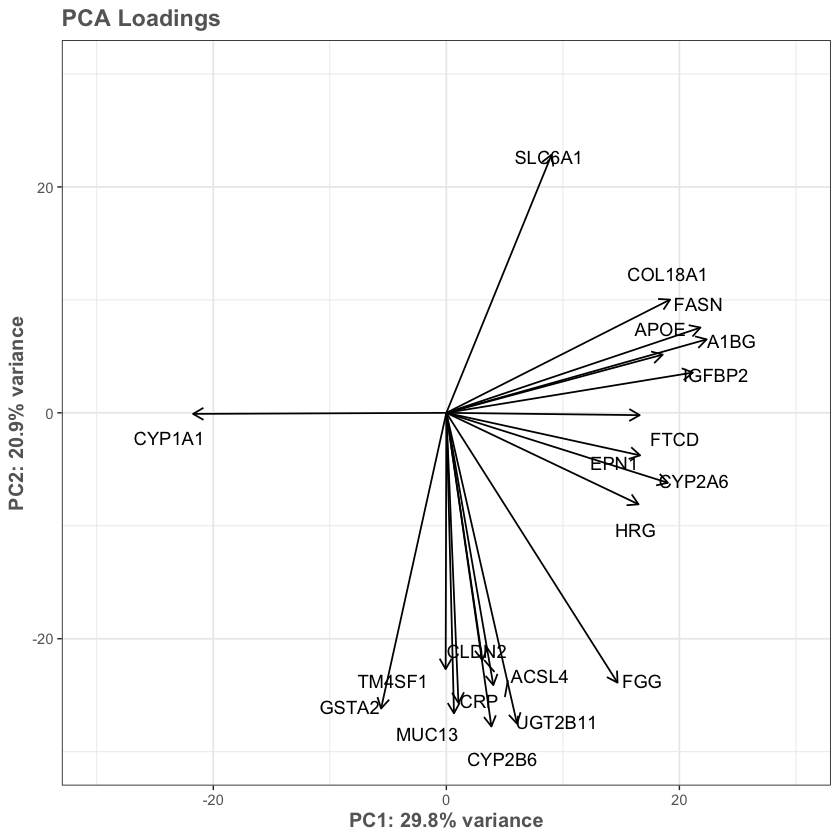

In [24]:
#install.packages("ggrepel")
suppressPackageStartupMessages(library(ggrepel))

textcol="grey40"
ggplot(top_load, aes(x=0, y=0))+
    geom_segment(aes(xend=PC1, yend=PC2), arrow=arrow(length= unit(0.1, "inches")))+
    geom_text_repel(aes(x=PC1+sign(PC1), y=PC2+sign(PC2), label=gene_name))+
    labs(x=paste0("PC1: ", round(percentVar[1], 4), "% variance"), 
         y=paste0("PC2: ", round(percentVar[2], 4), "% variance"),
         title= "PCA Loadings")+
    coord_cartesian(xlim=c(-30, 30), ylim=c(-30, 30))+
    theme_bw()+
    theme(plot.title=element_text(colour=textcol,hjust=0,size=14,face="bold"),
          axis.text.x=element_text(colour=textcol),
          axis.text.y=element_text(colour=textcol),
          axis.ticks=element_line(size=0.4),
          axis.title=element_text(colour= textcol, size=12, face="bold")
         )
ggsave("PC1PC2_Loadings.png", width=8, height=10)  

## Differential expression analysis

For the interesting part- we'll create a DEG list. `DESeq()` will do all the heavy lifting for us. All we need to do first, is use `relevel` to address which condition we are normalizing to.  
In the main paper, we compared each scaffold platform cultured in enhanced liver culture medium (eLCM) relative to regular hepatocyte culture medium (HCM). In the supplement, we then compared cross-platform cultured in eLCM. Here, we also include cross-platform comparisons in HCM alone. It may be, however, that the comparison is not as valid with HCM (and perhaps arguably with eLCM) between LiverChip cultures and spheroids at day 15 when the RNA was extracted. There may be differences in viability and RNA-degradation that make these different culture systems difficult to directly compare, especially in non-optimal media. Our main interest was the relative scaffold response to the media, and thus mostly examined each platform response to itself. However, we included these comparisons to more closely examine these discrepancies for those interested in furthering exploring the details of our dataset. 

In [26]:
#Making DEGs
dds<-DESeq(ddsTxi)
#These comparison names should be self-explanatory.
comp_names<-c("PS_eLCMvPEG_eLCM", "PS_eLCMvPS_Null", "PS_eLCMvAg_eLCM", 
              "PS_NullvAg_Null", "PEG_eLCMvPEG_Null", "PEG_eLCMvAg_eLCM", 
              "PEG_NullvAg_Null", "PS_NullvPEG_Null", "Ag_eLCMvAg_Null")

#Each comps matrix matches the corresponding conds as specified in comp_names. 
# e.g. PS_eLCMvPEG_eLCM corresponds to conds[2] (which is PS-eLCM) and conds[4] (which is PEG-eLCM).
comps<-list(c(conds[2], conds[4]), c(conds[2], conds[1]), c(conds[2], conds[6]), 
         c(conds[1], conds[5]), c(conds[4], conds[3]), c(conds[4], conds[6]), 
         c(conds[3], conds[5]), c(conds[1], conds[3]), c(conds[6], conds[5]))
names(comps)<-comp_names

# We then calculate the DEGs and save all DEGs and "significant" (padj<0.05) DEGs separately. 
# For GSEA we save a pre-ranked list sorted by "stat" as detailed in the methods. 
# This loop will take a long time due to translating gene names.

for (x in 1:length(comps)){
    restemp<-results(dds, contrast=c("condition", comps[[x]]))
    write.csv(restemp, file=paste0(names(comps[x]), "_DEG.csv"))
    ressigtemp<-subset(restemp, padj<0.05)
    write.csv(ressigtemp, file=paste0(names(comps[x]), "_DEG_sig.csv"))
    
    for (y in 1:nrow(restemp)){
        restemp$gene_name[y]<-id2gene[rownames(restemp)[y], "gene_name"]}
    
    prerank_stat<-c()
    prerank_stat$genenames <-restemp$gene_name
    prerank_stat$gsea_score <-restemp$stat
    write.table(prerank_stat, file=paste0(names(comps[x]), "_stat.rnk.txt"), 
                sep = "\t", row.names = F, col.names = F, quote=FALSE, eol = "\n")
} 
                                        
               


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



### Volcano plots

Volcano plots are created for all comparisons specified, with padj<0.05 considered significant.  

In [27]:
#opening DEG files                                        
degs<-list()
for (x in 1:length(comps)){
    degs[[x]]<-read.csv(file.path(paste0(names(comps[x]), "_DEG.csv")))
}

for (x in 1:length(comps)){
    temp<-degs[[x]]
    keep<-c()
    for (y in 1:nrow(temp)){
            if (is.na(temp$padj[y])){keep<-append(keep, FALSE)} 
            else {keep<-append(keep, TRUE)}
        }
    
    temp<-temp[keep, ]
    for (z in 1:nrow(temp)){
        if (temp$padj[z]>=0.05){temp$threshold[z]<-"Not Significant"}
        else if (temp$padj[z]<0.05 & temp$log2FoldChange[z]<0){temp$threshold[z]<-"Down-Regulated"}
        else if (temp$padj[z]<0.05 & temp$log2FoldChange[z]>0){temp$threshold[z]<-"Up-Regulated"}
    }
    
    #top 15 genes are labeled in the plots
    temp<-temp[order(temp$padj), ,drop=F]
    for (a in 1:nrow(temp)){
        if (a <= 15){temp$gene_name[a]<- id2gene[temp$X[a], "gene_name"]}
        else {temp$gene_name[a]<-"NA"}
        }

    ggplot(temp) +
        geom_point(aes(x=log2FoldChange, y=-log10(padj), color=threshold)) +
        geom_text_repel(data=head(temp, 15), aes(x=log2FoldChange, y=-log10(padj), label=gene_name)) +
        labs(x=expression("log"[2](Fold~Change)), y=expression(-log[10](FDR)), color= "")+
        scale_x_continuous(labels = scales::number_format(accuracy = 0.1)) +
        scale_y_continuous(labels = scales::number_format(accuracy = 0.1))+
        scale_color_manual(values=c("dodgerblue2", "grey50", "orangered2")) + 
        theme_bw()+
        theme(legend.position="none",
              axis.text.x=element_text(size=12, hjust=1, face="bold"),
              axis.text.y=element_text(size=12, vjust=0.5, face="bold"),
              axis.title=element_text(colour="black", size=12, face="bold"))
    
    ggsave(paste0(names(comps[x]), "_Volcano.png"), width=3.5, height=3.5)
    ggsave(paste0(names(comps[x]), "_Volcano_svg.svg"), width=3.5, height=3.5)
}                   

## Enrichment analysis

### topGO

**Note:** [topGO](https://bioconductor.org/packages/release/bioc/html/topGO.html) results were not included in the main paper, as we found that high-level results were relatively close to GSEA. However, it is of interest for future studies to look at these results more in-depth. 
The [vignette](http://www.bioconductor.org/packages/release/bioc/vignettes/topGO/inst/doc/topGO.pdf) for this package was surprisingly helpful. However, most of this code was generated from a [Biostars post](https://www.biostars.org/p/350710/).  
First, we need to create a data frame that includes just the gene ID and its p-value (from the log2fold change). From the data frame, we want to convert to a named vector of p-values. This is the form required to create a new topGO object. We found more meaningful results when the up-regulated and down-regulated DEGs were split into separate analyses. Both dot plots and tables are generated. 

In [31]:
# BiocManager::install("topGO")
# install.packages("gt")
# install.packages("tidyverse")
# install.packages("glue") 

suppressPackageStartupMessages({library(topGO)
                                library(gt)
                                library(tidyverse)
                                library(glue)})

#opening DEG files                                        
degs<-list()
for (x in 1:length(comps)){
    degs[[x]]<-read.csv(file.path(paste0(names(comps[x]), "_DEG.csv")))
}
                                        
for (x in 1:length(comps)){
    temp<-degs[[x]]
    up_filter<- temp$log2FoldChange >= 0
    temp_up<-temp[up_filter,]
    down_filter<- temp$log2FoldChange <= 0
    temp_down<-temp[down_filter,]
    tops<-list(temp_up, temp_down)
    
    for (y in 1:length(tops)){
        top_names<-c("UP", "DOWN")
        temp<-tops[[y]]
        toplist= data.frame(GeneID= temp$X, pvalue= temp$pvalue)
        topvector<-as.vector(c(t(toplist$pvalue)))
        names(topvector)<-as.vector(c(t(toplist$GeneID)))

        selection<-function(x){TRUE}
        allGO2genes<-annFUN.org(whichOnto="BP", feasibleGenes=NULL, mapping="org.Hs.eg.db", ID="ensembl")
        GOdata<-new("topGOdata", ontology="BP", allGenes= topvector, 
                annot=annFUN.GO2genes, GO2genes= allGO2genes, 
                geneSel=selection, nodeSize=10)
        ks_results<-runTest(GOdata, algorithn="weight01", statistic="ks")
        goTemp<-GenTable(GOdata, KS=ks_results, orderBy="KS", topNodes=1000)
        write.csv(goTemp, file=paste0(names(comps[x]), "_topGO_", top_names[y], ".csv"))
        if (y==1){
            goTemp$facet<-"Up-Regulated"
            goEnrichment<-goTemp[1:5, ,drop=FALSE]}
        if (y==2){
            goTemp$facet<-"Down-Regulated"
            goEnrichment<-rbind(goEnrichment, goTemp[1:5, ,drop=FALSE])}
        }
    save(goEnrichment, file=paste0(names(comps[x]), "_topGO.RData"))
}          



Building most specific GOs .....

	( 7897 GO terms found. )


Build GO DAG topology ..........

	( 12123 GO terms and 28324 relations. )


Annotating nodes ...............

	( 4886 genes annotated to the GO terms. )


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 3963 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


	 Level 17:	1 nodes to be scored	(0 eliminated genes)


	 Level 16:	6 nodes to be scored	(0 eliminated genes)


	 Level 15:	15 nodes to be scored	(11 eliminated genes)


	 Level 14:	49 nodes to be scored	(85 eliminated genes)


	 Level 13:	94 nodes to be scored	(202 eliminated genes)


	 Level 12:	159 nodes to be scored	(679 eliminated genes)


	 Level 11:	248 nodes to be scored	(1500 eliminated genes)


	 Level 10:	399 nodes to be scored	(2207 eliminated genes)


	 Level 9:	555 nodes to be scored	(2815 eliminated genes)


	 Level 8:	596 nodes to be scored	(3570 eliminated genes)


	 Level 7:	629 nodes to be scored	(4095 el


Annotating nodes ...............

	( 5218 genes annotated to the GO terms. )


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 3763 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


	 Level 16:	5 nodes to be scored	(0 eliminated genes)


	 Level 15:	13 nodes to be scored	(0 eliminated genes)


	 Level 14:	42 nodes to be scored	(64 eliminated genes)


	 Level 13:	85 nodes to be scored	(164 eliminated genes)


	 Level 12:	147 nodes to be scored	(619 eliminated genes)


	 Level 11:	242 nodes to be scored	(1490 eliminated genes)


	 Level 10:	391 nodes to be scored	(2389 eliminated genes)


	 Level 9:	524 nodes to be scored	(3069 eliminated genes)


	 Level 8:	560 nodes to be scored	(3864 eliminated genes)


	 Level 7:	591 nodes to be scored	(4389 eliminated genes)


	 Level 6:	518 nodes to be scored	(4742 eliminated genes)


	 Level 5:	353 nodes to be scored	(4932 eliminated genes)


	 Level 4:	184 nodes to be scored	(5061 eliminated genes)



	 Level 18:	1 nodes to be scored	(0 eliminated genes)


	 Level 17:	2 nodes to be scored	(0 eliminated genes)


	 Level 16:	7 nodes to be scored	(10 eliminated genes)


	 Level 15:	13 nodes to be scored	(12 eliminated genes)


	 Level 14:	42 nodes to be scored	(73 eliminated genes)


	 Level 13:	94 nodes to be scored	(165 eliminated genes)


	 Level 12:	152 nodes to be scored	(633 eliminated genes)


	 Level 11:	254 nodes to be scored	(1572 eliminated genes)


	 Level 10:	414 nodes to be scored	(2495 eliminated genes)


	 Level 9:	547 nodes to be scored	(3206 eliminated genes)


	 Level 8:	574 nodes to be scored	(4002 eliminated genes)


	 Level 7:	615 nodes to be scored	(4558 eliminated genes)


	 Level 6:	531 nodes to be scored	(4919 eliminated genes)


	 Level 5:	357 nodes to be scored	(5129 eliminated genes)


	 Level 4:	190 nodes to be scored	(5251 eliminated genes)


	 Level 3:	91 nodes to be scored	(5303 eliminated genes)


	 Level 2:	20 nodes to be scored	(5323 eliminated gene

#### Plotting topGO

In [34]:
                                        
simpleCap <- function(x) {
    s <- strsplit(x, " ")[[1]]
    paste(toupper(substring(s, 1, 1)), substring(s, 2), sep = "", collapse = " ")}
                                        
for (x in 1:length(comps)){
    
    load(file.path(paste0(names(comps[x]), "_topGO.RData")))
    
    
    goEnrichment$facet<-factor(goEnrichment$facet, levels=c("Up-Regulated", "Down-Regulated"))
    goEnrichment<- goEnrichment[as.numeric(goEnrichment$KS)<0.05,]
    goEnrichment<- goEnrichment[,c("GO.ID","Term","Significant","KS", "facet")] 
    goEnrichment$Term <- gsub(" [a-z]*\\.\\.\\.$", "", goEnrichment$Term) #clears any cutoff words
    goEnrichment$Term<-toupper(goEnrichment$Term)
    goEnrichment$Term <- factor(goEnrichment$Term, levels=rev(unique(goEnrichment$Term))) #freezes the order of the terms
    goEnrichment$KS <- as.numeric(goEnrichment$KS) 

    minKS= min(-log10(goEnrichment$KS))
    maxKS= max(-log10(goEnrichment$KS)) 
    
    for (y in 1:nrow(goEnrichment)){if (goEnrichment$Significant[y]<=25){goEnrichment$Significant[y]<-25} else if (goEnrichment$Significant[y]>=100){goEnrichment$Significant[y]<-100}}
    range<-0
    if (max(goEnrichment$Significant)==100){range<-8} else if (max(goEnrichment$Significant)>=75){range<-7} else if (max(goEnrichment$Significant)>=50){range<-6}
    
    # Dot plot, where size of the dot corresponds to term size
    ggplot(goEnrichment, aes(x=Term, y=-log10(KS)))+
             geom_point(aes(size= Significant), shape =21, fill="grey50", color="black")+
             labs(y=expression(-log[10](KS)), size= "GO Term Size")+
             scale_y_continuous(expand=c(0.25,0.25))+
             scale_size(range = c(2, range),
             breaks = c(25, 50, 75, 100),
             labels = c("<25", "50", "75", "100+"), trans="identity", guide="legend")+
             facet_grid(row=vars(facet), scales="free", space="free")+
             theme_bw() +
             theme(
                 legend.position="right",legend.direction="vertical",
                 legend.title=element_text(colour="black", size= 10, face="bold"),
                 legend.margin=margin(grid::unit(0,"cm")),
                 legend.spacing= grid::unit(1, "cm"),
                 legend.text=element_text(colour="black",size=10, face="bold"),
                 legend.key.height=grid::unit(0.8,"cm"),
                 legend.key.width=grid::unit(0.2,"cm"),
                 strip.text.x = element_text(size = 10, color = "black", face="bold"),
                 strip.background = element_rect(color="black", fill="white"),
                 axis.text.x=element_text(size=10, hjust=1, color="black", face="bold"),
                 axis.text.y=element_text(size=10, vjust=0.5, color="black", face="bold"),
                 axis.title.y=element_blank(),
                 axis.title.x=element_text(colour= "black", size=10, face="bold"))+
             coord_flip()
         ggsave(paste0(names(comps[x]),"_topGO_Dot.png"), width=6, height=4)
    
    table<-goEnrichment[, c("GO.ID","Term","KS"), drop=FALSE]
    table$KS<- -log10(table$KS)
    table$KS<- round(table$KS, 2)
    table$Term<-as.character(table$Term)
    for(z in 1:nrow(goEnrichment)){table$Term[z]<-simpleCap(table$Term[z])}
    title<-paste0("GO Term Enrichment in ", names(comps[x]))
    
    gt_tbl <- gt(data = table, rowname_col = "row",groupname_col = "group")%>% 
      tab_header(title = title)%>%
      tab_row_group(group = "Up-Regulated", rows = 1:5)%>%
      tab_row_group(group = "Down-Regulated", rows = 6:10)%>%
      cols_label(GO.ID="GO ID", Term="GO Term", KS=html("-log<sub>10</sub>(KS)"))%>%
      cols_align(align="left", columns= vars("Term"))%>%
      tab_style(style = list(cell_text(weight="bold")), locations = list(cells_title(groups = "title")))%>%
      tab_options(
          column_labels.font.weight="bold", 
          row_group.font.weight="bold")%>%
      row_group_order(groups = c("Up-Regulated", "Down-Regulated"))
    gtsave(data=gt_tbl, filename=paste0(names(comps[x]), "_topGO_Table.png"))
    }

#Warning messages can be ignored. There's probably a better way to make the table that avoids to messages. 

Warning message in min(rows_matched):
"no non-missing arguments to min; returning Inf"
Warning message in max(rows_matched):
"no non-missing arguments to max; returning -Inf"
Warning message in min(rows_matched):
"no non-missing arguments to min; returning Inf"
Warning message in max(rows_matched):
"no non-missing arguments to max; returning -Inf"
Warning message in min(rows_matched):
"no non-missing arguments to min; returning Inf"
Warning message in max(rows_matched):
"no non-missing arguments to max; returning -Inf"
Warning message in min(rows_matched):
"no non-missing arguments to min; returning Inf"
Warning message in max(rows_matched):
"no non-missing arguments to max; returning -Inf"
Warning message in min(rows_matched):
"no non-missing arguments to min; returning Inf"
Warning message in max(rows_matched):
"no non-missing arguments to max; returning -Inf"
Warning message in min(rows_matched):
"no non-missing arguments to min; returning Inf"
Warning message in max(rows_matched):


### Gene Set Enrichment Analysis

GSEA (Gene Set Enrichment Analysis), see [original paper](https://www.pnas.org/content/102/43/15545) and [website](https://www.gsea-msigdb.org/gsea/index.jsp), is rather straightforward once you format your data correctly. This comprehensive [video tutorial](https://www.youtube.com/watch?v=KY6SS4vRchY) is a helpful resource. Formatting is better addressed in the GSEA [User Guide](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html) and the [Wiki](http://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats). Also see Trapecar et al. methods.
Note that this section requires GSEA software (v4.1.0 is used in the paper)

We found that pre-ranking genes by "Stat" (Wald's test based on the negative binomial distribution) generated the most useful terms. These files were generated as "*_stat.rnk.txt" in the DEG section. Load these files directly into the GSEA program. Select Run GSEAPreranked and edit the run options: 
~~~
    Gene sets database- c2.cp.kegg.v7.2.symbols.gmt (desired database you want)
    Number of permutations-1000  
    Collapse-Collapse  
    Chip platform- Human_ENSEMBL_Gene_MSigD.v7.2.chip   
~~~
In the Basic fields, you can leave all of the default options, but you should choose a sensible name and an output folder. 

The run results can be quickly assessed by clicking the "Success" status in the lower left hand corner of the window. The full results folder contains all of the reports, enrichment plots, butterfly plots and heatmaps. Note that Windows users may have to manually rename files. To do pathway visualization, you'll need [Enrichment map](https://ap!(attachment:Enrichment%20Map.png)ps.cytoscape.org/apps/enrichmentmap), a [Cytoscape](https://cytoscape.org/download.html) plugin. Within GSEA, on the Enrichment Map Visualization tab, you simply load your results and choose your p- and q- value cutoffs. This requires that you have the Cytoscape application open and running.  

For this code, we created a folder "GSEA" in the working directory, where we moved all the GSEA outputs. Each folder is named after the "comp" terms corresponding to the comparisons we performed. The following code plots GSEA outputs as dot plots shown in the main text. Some terms, such as those relating to cancer or non-liver organs, were manually removed from the term list and the next most significant term was substituted. As GSEA is a tool for generating insights and hypotheses, some non-sensible terms can appear in these databases. A large or general gene set may contain a certain set of liver or inflammatory-specific upregulated genes that cause high enrichment. This can be examined more closely especially with the subsequent gene set heatmap section.  

In [36]:
# For ease of use, put the GSEA output folder in the working directory. 
# We ran comparisons on KEGG, Reactome, Hallmarks, and GO-Biological Processes
gseas<- list("GO_BP","KEGG","REACTOME","Hallmarks")

textcol="grey40"
f<- c(1, 2, 3, 4)
c<-c("dodgerblue2", "orangered2")

# comp names are now used as the folder / condition names in the GSEA output folder. Change accordingly. 
comps<- list("Ag_eLCMvPlatform","PEG_eLCMvPlatform","PS_eLCMvPlatform","PS_nullvPEGnull",
             "PS_nullvAgnull","PEG_nullvAgnull","PS_eLCMvAgeLCM","PEG_eLCMvAgeLCM","PS_eLCMvPEGeLCM")
           

for (b in gseas){
    gsealist <- list.files(file.path("GSEA",b),pattern = ".GseaPreranked")
    for (x in comps){
        # read GSEA TSV files from output folder. This can be tricky since GSEA output appears different on Mac and Windows - adjust accordingly. 
        idx <- grep(x, gsealist)
        gwd<-file.path("GSEA",b,paste0(gsealist[idx]))
        filename_up<-list.files(gwd, pattern = "^gsea_report_for_na_pos(.*)tsv$")
        filename_down<-list.files(gwd, pattern = "^gsea_report_for_na_neg(.*)tsv$")
        report_up<-read.table(file.path(gwd,filename_up), sep = "\t", header=TRUE)
        report_down<-read.table(file.path(gwd,filename_down), sep = "\t", header=TRUE)
        
        #save tables in easier to access format for downstream analysis
        write.csv(report_up, file = paste0(b,"_GSEA_",x,"_UP.csv"))
        write.csv(report_down, file = paste0(b,"_GSEA_",x,"_DOWN.csv"))
        
        set_sizes<-read.table(file.path(gwd,"gene_set_sizes.tsv"), sep = "\t", header=TRUE)
        for (y in 1:nrow(set_sizes)){if (is.na(set_sizes[y, "AFTER.RESTRICTING.TO.DATASET"])){set_sizes[y, "AFTER.RESTRICTING.TO.DATASET"]=0}}
        totalsize<-sum(set_sizes$AFTER.RESTRICTING.TO.DATASET)
        
        report_down$dir <- "Down-Regulated"
        report_up$dir <- "Up-Regulated"
        
        # For each database, we tweak the width, term cutoffs, and leave options for adjusting FDR cutoffs. 
        
        if  (b == "GO_BP") {
        up_filter <- (report_up$SIZE<250 & report_up$SIZE>15 & report_up$FDR.q.val <= 0.1)
        report_up_filter<-report_up[up_filter,]
        down_filter <- (report_down$SIZE<250 & report_down$SIZE>15 & report_down$FDR.q.val <= 0.1)
        report_down_filter<-report_down[down_filter,]
        wsize <- 8
            }
        # More forgiving filters for KEGG
        if (b == "KEGG") {
        up_filter <- report_up$FDR.q.val <= 0.1
        report_up_filter<-report_up[up_filter,]
        down_filter <- report_down$FDR.q.val <= 0.1
        report_down_filter<-report_down[down_filter,]
        wsize <- 7
            }
        # REACTOME
        if (b == "REACTOME") {
        up_filter <- report_up$FDR.q.val <= 0.1
        report_up_filter<-report_up[up_filter,]
        down_filter <- report_down$FDR.q.val <= 0.1
        report_down_filter<-report_down[down_filter,]
        wisize <- 10
            }
        
        # Hallmarks
        if (b == "Hallmarks") {
        up_filter <- report_up$FDR.q.val <= 0.1
        report_up_filter<-report_up[up_filter,]
        down_filter <- report_down$FDR.q.val <= 0.1
        report_down_filter<-report_down[down_filter,]
        wsize <- 7
            }
        
        # Plot more of up or down if less than "anno" sig genes on one side
        anno <- 7
        extra1 <- 0
        extra2 <- 0
        if (nrow(report_down_filter) < anno) {
            extra1 <- (anno - nrow(report_down_filter))
        }
        if (nrow(report_up_filter) < anno) {
            extra2 <- (anno - nrow(report_up_filter))
        }
        
        report_down_filter$NES <-report_down_filter$NES*(-1)
        
        gsea<-c()
        gsea<- report_up_filter[1:(anno+extra1), c("NAME", "NES", "FDR.q.val", "SIZE","dir")]
        ndown <- report_down_filter[1:(anno+extra2), c("NAME", "NES", "FDR.q.val", "SIZE","dir")]
        gsea<-rbind(gsea, ndown[nrow(ndown):1,])
        gsea<-na.omit(gsea)
        #formatting names
        gsea$NAME<- gsub("_", " ", gsea$NAME)
        gsea$NAME<- gsub(b,"", gsea$NAME)
        gsea$NAME<-gsub("GO ","", gsea$NAME)
        gsea$NAME<-gsub("HALLMARK ","",  gsea$NAME)
        
        # cut off longer terms
        for (zz in 1:nrow(gsea)){
          gsea$NAME[zz] <- str_trunc(gsea$NAME[zz],50)  
        }
        
        gsea$NAME<- factor(gsea$NAME, levels=rev(unique(gsea$NAME)))
        gsea$FDR.q.val[gsea$FDR.q.val < 0.0001] <- 0.0001 #replace "0" FDR values for plotting purposes
        gsea$FDR.q.val <- (-log10(gsea$FDR.q.val))
        for (y in 1:nrow(gsea)){if (gsea$SIZE[y]<=25){gsea$SIZE[y]<-25} else if (gsea$SIZE[y]>=100){gsea$SIZE[y]<-100}}
        gsea$dir_f <- factor(gsea$dir, levels=c("Up-Regulated", "Down-Regulated"))
  
        # plotting
        range<-0
        if (max(gsea$SIZE)==100){range<-6} else if (max(gsea$SIZE)>=75){range<-5} else if (max(gsea$SIZE)>=50){range<-4}
        
        ggplot(gsea, aes(x=NAME, y=NES))+
             geom_point(aes(fill= FDR.q.val, size = SIZE), shape = 21, color="black")+
             labs(title=paste0("GSEA, ", b, " ",x), y="|Normalized Enrichment Score (NES)|",
                  fill= expression(-log[10](FDR)), size= "Gene Set Size")+
             scale_y_continuous(breaks = waiver())+
             scale_fill_gradientn(limits= c(f[1],f[length(f)]), colors= c, breaks= f, labels=format(f))+ 
             scale_size(range = c(1, range),
             breaks = c(25, 50, 75, 100),
             labels = c("<25", "50", "75", "100+"), trans="identity", guide="legend")+
            facet_grid(dir_f~., scales="free", space="free_y")+
             theme_bw() +
             theme(
                 legend.position="right",legend.direction="vertical",
                 legend.title=element_text(colour=textcol, size= 10),
                 legend.margin=margin(grid::unit(0,"cm")),
                 legend.spacing= grid::unit(1, "cm"),
                 legend.text=element_text(colour=textcol,size=6,face="bold"),
                 legend.key.height=grid::unit(0.8,"cm"),
                 legend.key.width=grid::unit(0.2,"cm"),
                 plot.title=element_text(colour=textcol, size=10, face="bold", vjust=0),
                 axis.text.x=element_text(size=10, face="bold", hjust=1),
                 axis.text.y=element_text(size=10, face="bold", vjust=0.5),
                 axis.title=element_text(colour= textcol, size=10, face="bold"))+  
            #facet_grid(rows = vars(dir))+
             coord_flip()
         ggsave(paste0(x, "_", b, "_Dot_short.pdf"), width= wsize, height=4)
        ggsave(paste0(x, "_", b, "_Dot_short_svg.svg"), width= wsize, height=4)
    }
}


### Fold change gene set heatmaps

Based on the enrichment data, gene lists were downloaded from [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb). Each list is saved as a .txt with appended "_geneset.txt" to the name. These are saved to the "genesets" folder in the working directory. In order to reduce the size of each heatmap, an optional step we employed filtered out genes that were not significantly differentially expressed for any included condition. 


To plot the heatmaps with the annotated barplot, we used [ComplexHeatmap](https://academic.oup.com/bioinformatics/article/32/18/2847/1743594). Refer to the [Github](https://github.com/jokergoo/ComplexHeatmap) and [manual](https://jokergoo.github.io/ComplexHeatmap-reference/book/) for additional features. 

In [40]:
#BiocManager::install("ComplexHeatmap")
suppressPackageStartupMessages({library(ComplexHeatmap)
                                library(circlize)
                                library(svglite)
                                library(gridtext)})

genefiles<-list.files(file.path("genesets"))
genesets<-gsub("_geneset.txt","",genefiles)

# named comps for DEG .csv outputs. Which comparisons you use will change the dendrogram clustering. 

# platform comps
comps<- c("PS_eLCMvPS_Null","PEG_eLCMvPEG_Null","Ag_eLCMvAg_Null")
form_comps<-c("PSeLCMvPlat", "PEGeLCMvPlat", "AgeLCMvPlat")


# cross-scaffold comps, commented out
# comps<- c("PS_eLCMvPEG_eLCM","PS_eLCMvAg_eLCM","PEG_eLCMvAg_eLCM")
# form_comps<-c("PSvPEG", "PSvSph", "PEGvSph")


for (w in 1:length(genesets)){
    genesetsname <- gsub("_", " ", genesets[w])
    
    # keep only genes that map to ddsTxi list (see previous sections)
    probe<-read.delim(file.path("genesets", genefiles[w]))
    probe<-probe[(2:nrow(probe)),1]
    keep<-c()
    temp<-c()
    for (x in 1:length(probe)){
        temp<-gene2id[probe[x], "id"]
        if (temp %in% rownames(ddsTxi)){keep<-append(keep, TRUE)
            } else {keep<-append(keep, FALSE)}
        }
    probe<-probe[keep]
    
    # create heatmap data                   
    heatdata<-matrix(1:(length(comps)*length(probe)), ncol=length(comps))     
    for (x in 1:length(comps)){      
        restemp <- read.csv(file.path(paste0(comps[x], "_DEG.csv")), header=T, row.names=1)     
        for (y in 1:length(probe)){       
            temp<-gene2id[probe[y],"id"]
            heatdata[y,x]<-restemp[temp,]$log2FoldChange
        }
    } 
    
    # pull list of sig genes and match with geneset
    sigcompsindex<-matrix(0, nrow=length(probe), ncol=length(comps))
    sigcompscount<-matrix(0, nrow=length(probe), ncol=length(comps))
    for (x in 1:length(comps)){
        resigtemp<- read.csv(file.path(paste0(comps[x], "_DEG_sig.csv")), header=T, row.names=1) 
        for (y in 1:length(probe)){
            temp<-gene2id[probe[y], "id"]
            if (temp %in% rownames(resigtemp)) {
                if (resigtemp[temp,]$log2FoldChange > 0) {
                    sigcompsindex[y,x] <- 1
                    #sigup<-append(sigup, probe[y])
                } else {
                    #sigdown<-append(sigdown, probe[y])
                    sigcompsindex[y,x] <- -1
                }
                sigcompscount[y,x] <- sigcompscount[y,x] + 1
            }
        }
    }
    # remove rows with no sig DEGs for any comp
    keep<-c()
    for (x in 1:nrow(sigcompscount)) {
        if (rowSums(sigcompscount)[x]>0) {keep<-append(keep, TRUE)
            } else {keep<-append(keep, FALSE)}
        }
    
    # comment out next 3 lines to remove filter
    # probe <- probe[keep]
    # sigcompsindex <- sigcompsindex[keep,]
    # heatdata <- heatdata[keep,]
    
    sigcomps<-matrix(nrow=3, ncol=length(comps))
    for (x in 1:length(comps)){
        upreg<-length(subset(sigcompsindex[,x],sigcompsindex[,x]==1))
        downreg<-length(subset(sigcompsindex[,x],sigcompsindex[,x]==-1))
        nonsig<-length(subset(sigcompsindex[,x],sigcompsindex[,x]==0))
        sigcomps[,x]<-c(upreg/length(probe), downreg/length(probe), nonsig/length(probe))
    }
    
    rownames(heatdata)<-probe
    colnames(heatdata)<-form_comps

    colnames(sigcomps)<-form_comps
    rownames(sigcomps)<-c("up-regulated", "down-regulated", "non-significant")
    
    
    # Complex heatmap plot
    # annotation barplot
    column_ha = HeatmapAnnotation(SigFrac=anno_barplot(t(sigcomps), 
                                  border=FALSE, bar_width = 1, 
                                  gp = gpar(fill = c("orangered2", "dodgerblue2", "grey70")),
                                  axis_param = list(gp = gpar(fontsize = 8, fontface = "bold"))), 
                                  annotation_label= gt_render(c("Sig. Fraction"), gp =  gpar(fontsize = 10, fontface = "bold")))
    
    col_fun = colorRamp2(c(-2, 0, 2), c("dodgerblue2", "white", "orangered2"))
    
    label_size=10
    if(length(probe)>50){label_size=8} 
    if(length(probe)>75){label_size=6}
    
    ht = Heatmap(heatdata, 
                 column_title = genesetsname, 
                 column_title_gp = gpar(fontsize = 15, fontface = "bold"),
                 top_annotation = column_ha,
                 heatmap_legend_param = list(title ="log2FC", title_gp = gpar(fontsize = 10, fontface = "bold"), 
                                        title_position = "topcenter", labels_gp = gpar(fontsize = 8, fontface = "bold"), 
                                        legend_height= unit(4, "cm")), 
                 col_fun, 
                 clustering_distance_rows = "euclidean",
                 row_dend_reorder = TRUE,
                 #column_split = factor(rep(c("Platform", "Null", "eLCM"), each= 3), levels=c("Platform", "Null", "eLCM")),
                 cluster_column_slices = FALSE, 
                 column_names_rot = 45, 
                 column_names_gp = gpar(fontsize = 10, fontface = "bold"),
                 row_names_gp = gpar(fontsize = label_size, fontface = "bold"),
                 border=TRUE,
                 row_dend_width = unit(1.5, "cm"),
                 height = nrow(heatdata)*unit(3, "mm"))
    
    svglite(file=paste0(genesets[w], "_Heatmap_FC_Plat.svg"), height=12, width = 3)
    HM<-draw(ht)
    dev.off()
    pdf(file=paste0(genesets[w], "_Heatmap_FC_Plat.pdf"), height=12, width = 3)
    HM<-draw(ht)
    dev.off()
    }

## Venn diagram: overlapping DEGs and enrichment terms

We generated overlapping terms from our GSEA enrichment analysis, as well as the DEGs exported into a .csv file. The venn diagram was drawn using [BioVenn](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-9-488) and Adobe Illustrator. We were most interested in the up-regulated overlapping and unique terms, but this can easily be reconfigured for down-regulated terms. 

In [45]:
#Extracting values for VennDiagram. This process can probably be optimized further. 

venn_go<-c("PS_eLCMvPS_Null", "PEG_eLCMvPEG_Null", "Ag_eLCMvAg_Null")
venn_gsea<-c("PS_eLCMvPlatform","PEG_eLCMvPlatform","Ag_eLCMvPlatform")
venn_cat<-c("topGO", "GO_BP", "KEGG","REACTOME","Hallmarks")
names(venn_cat)<-c("topGO", rep("GSEA", 4))

for (b in 1:length(venn_cat)){
    if(names(venn_cat[b])=="topGO"){
        report1<- read.csv(file.path(paste0(venn_go[1], "_", venn_cat[b], "_UP.csv")), header=T)  
        filter<- report1$KS <= 0.1  
        report1_terms<- report1[filter, "Term"]

        report2<- read.csv(file.path(paste0(venn_go[2], "_", venn_cat[b], "_UP.csv")), header=T)  
        filter<- report2$KS <= 0.1  
        report2_terms<- report2[filter, "Term"]

        report3<- read.csv(file.path(paste0(venn_go[3], "_", venn_cat[b], "_UP.csv")), header=T)  
        filter<- report3$KS <= 0.1  
        report3_terms<- report3[filter, "Term"]
        }
    
    if(names(venn_cat[b])=="GSEA"){
        report1<- read.csv(file.path(paste0(venn_cat[b],"_GSEA_", venn_gsea[1],"_UP.csv")), header=T)  
        filter<- report1$FDR.q.val <= 0.1  
        report1_terms<- report1[filter, "NAME"]

        report2<- read.csv(file.path(paste0(venn_cat[b],"_GSEA_", venn_gsea[2],"_UP.csv")), header=T)
        filter<- report2$FDR.q.val <= 0.1  
        report2_terms<- report2[filter, "NAME"]

        report3<- read.csv(file.path(paste0(venn_cat[b],"_GSEA_", venn_gsea[3],"_UP.csv")), header=T)
        filter<- report3$FDR.q.val <= 0.1  
        report3_terms<- report3[filter, "NAME"]
        }
    
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (report1_terms[x] %in% report2_terms & report1_terms[x] %in% report3_terms){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        allshare<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (report1_terms[x] %in% report2_terms & !(report1_terms[x] %in% report3_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        onetwo_share<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (!(report1_terms[x] %in% report2_terms) & report1_terms[x] %in% report3_terms){keep<-append(keep, TRUE)}  
        else{keep<-append(keep, FALSE)} 
        onethree_share<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report2_terms)){
        if (report2_terms[x] %in% report3_terms & !(report2_terms[x] %in% report1_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        twothree_share<-report2_terms[keep]}
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (!(report1_terms[x] %in% report2_terms) & !(report1_terms[x] %in% report3_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        one_unique<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report2_terms)){
        if (!(report2_terms[x] %in% report1_terms) & !(report2_terms[x] %in% report3_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        two_unique<-report2_terms[keep]}
    keep<-c()
    for (x in 1:length(report3_terms)){
        if (!(report3_terms[x] %in% report1_terms) & !(report3_terms[x] %in% report2_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        three_unique<-report3_terms[keep]}
    
    VennConds= c(venn[1], venn[2], venn[3])
    OriginalSize=c(length(report1_terms), length(report2_terms), length(report3_terms))
    
    max.len = max(length(allshare), length(onetwo_share), length(onethree_share), length(twothree_share), 
                  length(one_unique), length(two_unique), length(three_unique))
    VennConds= c(VennConds, rep(NA, max.len - length(VennConds)))
    OriginalSize= c(OriginalSize, rep(NA, max.len - length(OriginalSize)))
    allshare= c(allshare, rep(NA, max.len - length(allshare)))
    onetwo_share= c(onetwo_share, rep(NA, max.len - length(onetwo_share)))
    onethree_share= c(onethree_share, rep(NA, max.len - length(onethree_share)))
    twothree_share= c(twothree_share, rep(NA, max.len - length(twothree_share)))
    one_unique= c(one_unique, rep(NA, max.len - length(one_unique)))
    two_unique= c(two_unique, rep(NA, max.len - length(two_unique)))
    three_unique= c(three_unique, rep(NA, max.len - length(three_unique)))
    
    vt<-data.frame(VennConds= VennConds, OriginalSize=OriginalSize, allshare=allshare, onetwoshare=onetwo_share, onethreeshare=onethree_share, 
                  twothreeshare=twothree_share, oneunique=one_unique, twounqiue=two_unique, 
                  threeunique=three_unique) 
    write.csv(vt, file=paste0("VennDiagram_contents_", venn_cat[b], ".csv"))
}

In [46]:
#Extracting values for VennDiagram for sig degs 

comp_names<-c("PS_eLCMvPEG_eLCM", "PS_eLCMvPS_Null", "PS_eLCMvAg_eLCM", 
              "PS_NullvAg_Null", "PEG_eLCMvPEG_Null", "PEG_eLCMvAg_eLCM", 
              "PEG_NullvAg_Null", "PS_NullvPEG_Null", "Ag_eLCMvAg_Null")
comps<-list(c(conds[2], conds[4]), c(conds[2], conds[1]), c(conds[2], conds[6]), 
         c(conds[1], conds[5]), c(conds[4], conds[3]), c(conds[4], conds[6]), 
         c(conds[3], conds[5]), c(conds[1], conds[3]), c(conds[6], conds[5]))
names(comps)<-comp_names


#opening sig DEG files    
degs_sig<-list()
for (x in 1:length(comps)){
    degs_sig[[x]]<-read.csv(file.path(paste0(names(comps[x]), "_DEG_sig.csv")))
}

venn<-c("PS_eLCMvPS_Null", "PEG_eLCMvPEG_Null", "Ag_eLCMvAg_Null")

report1_terms<-degs_sig[[2]][,"X"]
report2_terms<-degs_sig[[5]][,"X"]
report3_terms<-degs_sig[[9]][,"X"]

    keep<-c()
    for (x in 1:length(report1_terms)){
        if (report1_terms[x] %in% report2_terms & report1_terms[x] %in% report3_terms){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        allshare<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (report1_terms[x] %in% report2_terms & !(report1_terms[x] %in% report3_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        onetwo_share<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (!(report1_terms[x] %in% report2_terms) & report1_terms[x] %in% report3_terms){keep<-append(keep, TRUE)}  
        else{keep<-append(keep, FALSE)} 
        onethree_share<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report2_terms)){
        if (report2_terms[x] %in% report3_terms & !(report2_terms[x] %in% report1_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        twothree_share<-report2_terms[keep]}
    keep<-c()
    for (x in 1:length(report1_terms)){
        if (!(report1_terms[x] %in% report2_terms) & !(report1_terms[x] %in% report3_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        one_unique<-report1_terms[keep]}
    keep<-c()
    for (x in 1:length(report2_terms)){
        if (!(report2_terms[x] %in% report1_terms) & !(report2_terms[x] %in% report3_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        two_unique<-report2_terms[keep]}
    keep<-c()
    for (x in 1:length(report3_terms)){
        if (!(report3_terms[x] %in% report1_terms) & !(report3_terms[x] %in% report2_terms)){keep<-append(keep, TRUE)} 
        else{keep<-append(keep, FALSE)}
        three_unique<-report3_terms[keep]}
    
    VennConds= c(venn[1], venn[2], venn[3])
    OriginalSize=c(length(report1_terms), length(report2_terms), length(report3_terms))
    
    max.len = max(length(allshare), length(onetwo_share), length(onethree_share), length(twothree_share), 
                  length(one_unique), length(two_unique), length(three_unique))

    VennConds= c(VennConds, rep(NA, max.len - length(VennConds)))
    OriginalSize= c(OriginalSize, rep(NA, max.len - length(OriginalSize)))
    allshare= c(allshare, rep(NA, max.len - length(allshare)))
    onetwo_share= c(onetwo_share, rep(NA, max.len - length(onetwo_share)))
    onethree_share= c(onethree_share, rep(NA, max.len - length(onethree_share)))
    twothree_share= c(twothree_share, rep(NA, max.len - length(twothree_share)))
    one_unique= c(one_unique, rep(NA, max.len - length(one_unique)))
    two_unique= c(two_unique, rep(NA, max.len - length(two_unique)))
    three_unique= c(three_unique, rep(NA, max.len - length(three_unique)))
    
    vt<-data.frame(VennConds= VennConds, OriginalSize=OriginalSize, allshare=allshare, onetwoshare=onetwo_share, onethreeshare=onethree_share, 
                  twothreeshare=twothree_share, oneunique=one_unique, twounqiue=two_unique, 
                  threeunique=three_unique) 
    write.csv(vt, file="VennDiagram_contents_degs.csv")